## Discriminating Between Sonar Signals Bounced Off a Metal Cylinder and Those Bounced Off a Roughly Cylindrical Rock

## 1. Introduction

Sonar is a technique that uses sound propagation characteristics to detect objects by emitting sound pulses and detecting or measuring their return after reflection, used as a means of acoustic location by measuring the echo characteristics of the object. Our project is based on identifying the differences between the sonar returns from an undersea metal cylinder and a cylindrically shaped rock.

In our research we are trying to determine if there is any difference between the Sonar signals bounced off a metal cylinder and those bounced off a cylindrical rock. Thus, the question we will try to answer in our project: Is the object that bounces off a chosen sonar signal a metal cylinder or a cylindrical rock?

The dataset we will use contains signals bounced off a metal cylinder and a roughly cyclindrical rock obtained from a variety of different aspect angles. The angles spanned from 0 to 90 degrees for the metal cylinder and 0 to 180 degrees for the rock. The dataset does not list the explict aspect angles and states that the angles are not equally spaced apart. Thus each of the angles will be named AA_$n$ where $n$ is the $n$th variable. This is to reflect the fact that the angles do not have an explicit degree. The dataset does not list units for the return signal.

## 2. Methods and Results

In this project, we will be using K-nearest neighbor classification algorithm.

First, all the necessary packages were loaded using the library function. Using the read_csv function, the dataset was downloaded from the University of California Irvin's archives (Dua and Graff, 2019).

The set.seed function allows the results to be reproducible.

Since the original data set does not contain the column names, we named from the first columns to the 60th columns as from AA_1 to AA_60 respectively. We named the last column as Rocks_or_Mines, indicating whether the material that bounces off the sonar signals is a rock or mine.

Next, since we need to predict classification, we converted the column Rocks_or_Mines into a factor value.

In [ ]:
options(warn=-1)
library(tidyverse)
library(tidymodels)
library(readxl)
library(repr)
options(repr.matrix.max.rows = 6)

In [ ]:
sonar <- read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/undocumented/connectionist-bench/sonar/sonar.all-data",
                  col_names = FALSE)

set.seed(2022)

sonar_column_names <- c()
for (i  in 1:60) {sonar_column_names <- c(sonar_column_names, paste("AA", as.character(i), sep = "_"))}
sonar_column_names <- c(sonar_column_names, "Rocks_or_Mines")
colnames(sonar) <- sonar_column_names

sonar <- sonar %>% 
         mutate(Rocks_or_Mines = as_factor(Rocks_or_Mines)) %>%
         mutate(Rocks_or_Mines = recode(Rocks_or_Mines, R = "Rock", M = "Metal"))
print("Table 1: Sonar Data")
head(sonar)

In [3]:
# Split data to training data and testing data
sonar_split <- initial_split(sonar, prop = 0.75, strata = Rocks_or_Mines)
sonar_training <- training(sonar_split)
print("Table 2: Sonar Training Dataset")
sonar_training
sonar_testing <- testing(sonar_split)
print("Table 3: Sonar Testing Dataset")
sonar_testing

[1] "Table 2: Sonar Training Dataset"


AA_1,AA_2,AA_3,AA_4,AA_5,AA_6,AA_7,AA_8,AA_9,AA_10,⋯,AA_52,AA_53,AA_54,AA_55,AA_56,AA_57,AA_58,AA_59,AA_60,Rocks_or_Mines
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
0.0453,0.0523,0.0843,0.0689,0.1183,0.2583,0.2156,0.3481,0.3337,0.2872,⋯,0.0084,0.0089,0.0048,0.0094,0.0191,0.0140,0.0049,0.0052,0.0044,Rock
0.0100,0.0171,0.0623,0.0205,0.0205,0.0368,0.1098,0.1276,0.0598,0.1264,⋯,0.0121,0.0036,0.0150,0.0085,0.0073,0.0050,0.0044,0.0040,0.0117,Rock
0.0762,0.0666,0.0481,0.0394,0.0590,0.0649,0.1209,0.2467,0.3564,0.4459,⋯,0.0031,0.0054,0.0105,0.0110,0.0015,0.0072,0.0048,0.0107,0.0094,Rock
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋱,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
0.0272,0.0378,0.0488,0.0848,0.1127,0.1103,0.1349,0.2337,0.3113,0.3997,⋯,0.0091,0.0045,0.0043,0.0043,0.0098,0.0054,0.0051,0.0065,0.0103,Metal
0.0187,0.0346,0.0168,0.0177,0.0393,0.1630,0.2028,0.1694,0.2328,0.2684,⋯,0.0116,0.0098,0.0199,0.0033,0.0101,0.0065,0.0115,0.0193,0.0157,Metal
0.0260,0.0363,0.0136,0.0272,0.0214,0.0338,0.0655,0.1400,0.1843,0.2354,⋯,0.0146,0.0129,0.0047,0.0039,0.0061,0.0040,0.0036,0.0061,0.0115,Metal


[1] "Table 3: Sonar Testing Dataset"


AA_1,AA_2,AA_3,AA_4,AA_5,AA_6,AA_7,AA_8,AA_9,AA_10,⋯,AA_52,AA_53,AA_54,AA_55,AA_56,AA_57,AA_58,AA_59,AA_60,Rocks_or_Mines
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
0.0200,0.0371,0.0428,0.0207,0.0954,0.0986,0.1539,0.1601,0.3109,0.2111,⋯,0.0027,0.0065,0.0159,0.0072,0.0167,0.0180,0.0084,0.0090,0.0032,Rock
0.0262,0.0582,0.1099,0.1083,0.0974,0.2280,0.2431,0.3771,0.5598,0.6194,⋯,0.0232,0.0166,0.0095,0.0180,0.0244,0.0316,0.0164,0.0095,0.0078,Rock
0.0039,0.0063,0.0152,0.0336,0.0310,0.0284,0.0396,0.0272,0.0323,0.0452,⋯,0.0062,0.0120,0.0052,0.0056,0.0093,0.0042,0.0003,0.0053,0.0036,Rock
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋱,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
0.0323,0.0101,0.0298,0.0564,0.0760,0.0958,0.0990,0.1018,0.1030,0.2154,⋯,0.0061,0.0093,0.0135,0.0063,0.0063,0.0034,0.0032,0.0062,0.0067,Metal
0.0522,0.0437,0.0180,0.0292,0.0351,0.1171,0.1257,0.1178,0.1258,0.2529,⋯,0.0160,0.0029,0.0051,0.0062,0.0089,0.0140,0.0138,0.0077,0.0031,Metal
0.0303,0.0353,0.0490,0.0608,0.0167,0.1354,0.1465,0.1123,0.1945,0.2354,⋯,0.0086,0.0046,0.0126,0.0036,0.0035,0.0034,0.0079,0.0036,0.0048,Metal


By looking at Table 1,2 and 3, all the columns except Rocks_or_Mines are numerical variables. Rocks_or_Mines is catagorical variable.

### 2.1 Data Summary

To examine how the overall data looks like, we summarize the data with the number of observations and the mean value of the angles at each angle.

In [ ]:
print("Table 4: Observation counts, average values of sonar angles for metal and rock objects")
# sonar %>%
# group_by(Rocks_or_Mines) %>%
# # summarize(num_observ = n(), 
# #           AA_1_mean = mean(AA_1), 
# #           AA_2_mean = mean(AA_2), 
# #           AA_3_mean = mean(AA_3), 
# #           AA_4_mean = mean(AA_4), 
# #           AA_5_mean = mean(AA_5))
# summarize(num_observ = n())

sonar_means <- summarise_if(sonar, is.numeric, mean)
    sonar_obs_means <- sonar %>%
    group_by(Rocks_or_Mines) %>%
    summarize(num_observ = n()) %>%
    bind_cols(sonar_means)
    sonar_obs_means

From Table 4, the number of observations for rocks and mines is nearly the same. Looking at the mean value of sonar signals, as the order of angles increase, the sonar signals also increase at least until the 8th angle. From the 51st angle to the 60th angle, the sonar signlas decrease. However, we cannot see the overall trend due to a large number of angles.

Therefore, in order to get more information about these variables, we created a histogram to visualize the distribution of return signals of rock and metal in the next section.

### 2.2 Data Visualization

In [ ]:
# Set size of plots
options(repr.plot.width = 30, repr.plot.height = 10)

# Tidy data
sonar_longer <- pivot_longer(sonar_obs_means,
            cols = AA_1:AA_60,
            names_to = "angle",
            values_to = "return_measurement") %>%
            # filter(angle == "AA_1" | angle == "AA_2" | angle == "AA_3" | angle == "AA_4" | angle == "AA_5") %>%
            mutate(angle = as_factor(angle))

# plot the distribution of return signals of rock and metal for all angles
# sonar_longer %>% ggplot(aes(x = return_measurement)) + 
#    geom_histogram(binwidth = 0.01) +
#    xlab("Sonar return signal") + 
#    ylab("Frequency") +
#    labs(title = "Graph 1: Distribution of return signals of rock and metal for first five angles") +
#    facet_grid(angle ~ Rocks_or_Mines, scales = "free",
#               switch = "y") +
#    theme(axis.text.x = element_text(angle = 90, hjust = 0.5),
#         strip.text.y.left = element_text(angle = 0),
#         text = element_text(size = 20))

# Plot a bar graph of return measurement of all angles of rock and metal
sonar_distrib_hist <- sonar_longer %>% ggplot(aes(x = angle, y = return_measurement)) +
    geom_bar(stat = "identity") +
    labs(x = "The angles", y = "Return Measurement", title = "Graph 1: Bar graph of return measurement of all angles of rock and metal") +
    facet_grid(rows = vars(Rocks_or_Mines)) + 
    theme(axis.text.x = element_text(angle = 90, hjust = 0.5),
        text = element_text(size = 20))
sonar_distrib_hist

Graph 1 showed the overall trend of the dataset. For both rock and metal, the data is bell-shaped. The returned sonar signals from rocks increase as the angle increases until the 26th angle, and decreases. Likewise, the sonar signals from metals have the same trend with the peak at the 27th angle.

### 2.3 Data Analysis

To conduct the data analysis, we will use all the columns. Even though it is not ideal to use all the columns for data analysis in many cases, in our case the columns named AA_1 to AA_60 represent 60 different features used to identify whether the object that bounces of a chosen sonar signal a metal cylinder or a cylindrical rock. Each of these 60 features are equally important to discriminate between the sonar signals.


In order to choose the optimal K value for the KNN classification, we used cross-validation method.

The vfold_cv function splits the training data into 5 validation datasets. 

By calling the nearest_neighbor function, we create a model specification. The weight function specifies "rectangular" so that each of the K nearest neighbors gets exactly 1 vote. Rather than specifying a parciular value for neighobrs, they are tuned to identify the best K value. In the set_engine argument, kknn is the R package for performing KNN neighbors classification. Finally, we specify that this is a classification problem with the set_mode function.

Next, we create the recipe from the training dataset, identifying the Rocks_or_Mines as the target variable and all angles as the predictors. We also scale and cetner all the predictors to standardize the size of the sclae effects.

Then we create a data analysis workflow from the recipe and model we created earlier. We run the cross-validation and collect the information about the mean and standard error of the classifier’s validation accuracy across the folds. 

We identify the rows with accuracy value from ".metric" column and plot the graph the relationship between the estimated accuracies and K values(neighbors).

[1] "Table 5: Metrics with Accuracies"


neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
2,accuracy,binary,0.8352419,5,0.01963459,Model01
4,accuracy,binary,0.7904704,5,0.02277025,Model02
5,accuracy,binary,0.7898522,5,0.02384489,Model03
⋮,⋮,⋮,⋮,⋮,⋮,⋮
11,accuracy,binary,0.6950672,5,0.03509797,Model08
13,accuracy,binary,0.6879839,5,0.02986204,Model09
14,accuracy,binary,0.6879839,5,0.02986204,Model10


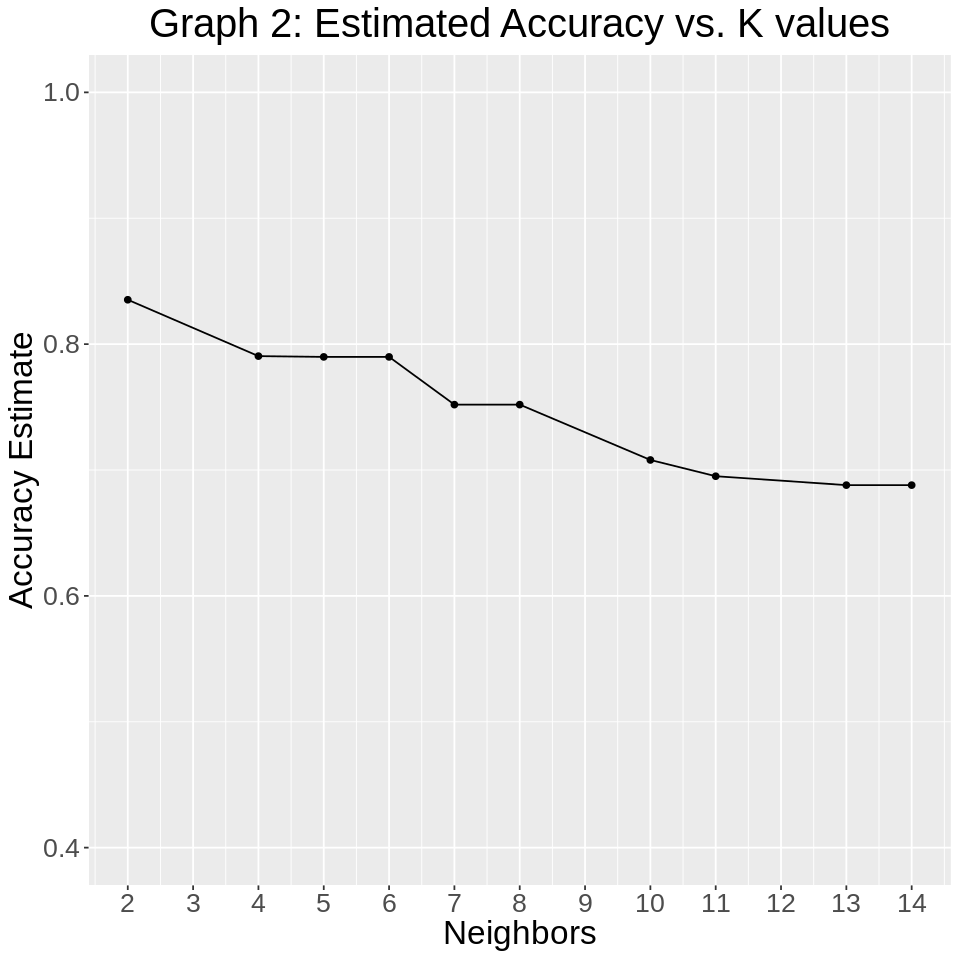

In [8]:
# Set the same seed
set.seed(2022)

# Perform 5-fold cross-validation
sonar_vfold <- vfold_cv(sonar_training, v = 5, strata = Rocks_or_Mines)

# create a model specification for K-nearest neighbors classification and set neighbors to tune
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
    set_engine("kknn") %>%
    set_mode("classification")

# Standardize all predictors by recipe
sonar_recipe <- recipe(Rocks_or_Mines ~., data = sonar_training) %>%
    step_scale(all_predictors()) %>%
    step_center(all_predictors())

# Creat a workflow to find the best K value
knn_results <- workflow() %>%
    add_recipe(sonar_recipe) %>%
    add_model(knn_spec) %>%
    tune_grid(resamples = sonar_vfold, grid = 10) %>%
    collect_metrics()

# Select accuracy
accuracies <- knn_results %>%
    filter(.metric == "accuracy")
print("Table 5: Metrics with Accuracies")
accuracies

options(repr.plot.width = 8, repr.plot.height = 8)
# Plot Estimated Accuracy verus K value(Neighbors) to find best k
accuracy_vs_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(x = "Neighbors", y = "Accuracy Estimate") + 
    ggtitle("Graph 2: Estimated Accuracy vs. K values") +
    scale_x_continuous(breaks = seq(0, 20, by = 1)) +
    scale_y_continuous(limits = c(0.4, 1.0)) +
    theme(plot.title = element_text(hjust = 0.5), 
          text = element_text(size = 20))

accuracy_vs_k

According Graph 2, we chose K = 2 as the optimal K value because it has the highest accuracy.
Now we recreate the KNN classification specification with K = 2 using the training dataset and predict the Rocks_or_Mines in the testing dataset. 

In [9]:
# Using the best K value to creat classification model
sonar_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 2) %>% 
    set_engine("kknn") %>%
    set_mode("classification")

# Creat the fit model for the best K value
sonar_fit <- workflow() %>%
    add_recipe(sonar_recipe) %>%
    add_model(sonar_spec) %>%
    fit(data = sonar_training)

# Using model to predict testing data
sonar_test_predictions <- predict(sonar_fit, sonar_testing) %>%
    bind_cols(sonar_testing)
print("Table 6: Prediction of Sonar Testing DataSet")
sonar_test_predictions

# Compute prediction accuracy
sonar_prediction_accuracy <- sonar_test_predictions %>%
    metrics(truth = Rocks_or_Mines, estimate = .pred_class) %>%
    filter(.metric == "accuracy")
print("Table 7: Prediction Accuracy")
sonar_prediction_accuracy

# Find confusion matrix of Rocks and Mines
confusion <- sonar_test_predictions %>%
    conf_mat(truth = Rocks_or_Mines, estimate = .pred_class)
print("Table 8: Confusion Matrix of Rocks and Mines")
confusion

[1] "Table 6: Prediction of Sonar Testing DataSet"


.pred_class,AA_1,AA_2,AA_3,AA_4,AA_5,AA_6,AA_7,AA_8,AA_9,⋯,AA_52,AA_53,AA_54,AA_55,AA_56,AA_57,AA_58,AA_59,AA_60,Rocks_or_Mines
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
Rock,0.0200,0.0371,0.0428,0.0207,0.0954,0.0986,0.1539,0.1601,0.3109,⋯,0.0027,0.0065,0.0159,0.0072,0.0167,0.0180,0.0084,0.0090,0.0032,Rock
Rock,0.0262,0.0582,0.1099,0.1083,0.0974,0.2280,0.2431,0.3771,0.5598,⋯,0.0232,0.0166,0.0095,0.0180,0.0244,0.0316,0.0164,0.0095,0.0078,Rock
Rock,0.0039,0.0063,0.0152,0.0336,0.0310,0.0284,0.0396,0.0272,0.0323,⋯,0.0062,0.0120,0.0052,0.0056,0.0093,0.0042,0.0003,0.0053,0.0036,Rock
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋱,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
Metal,0.0323,0.0101,0.0298,0.0564,0.0760,0.0958,0.0990,0.1018,0.1030,⋯,0.0061,0.0093,0.0135,0.0063,0.0063,0.0034,0.0032,0.0062,0.0067,Metal
Metal,0.0522,0.0437,0.0180,0.0292,0.0351,0.1171,0.1257,0.1178,0.1258,⋯,0.0160,0.0029,0.0051,0.0062,0.0089,0.0140,0.0138,0.0077,0.0031,Metal
Metal,0.0303,0.0353,0.0490,0.0608,0.0167,0.1354,0.1465,0.1123,0.1945,⋯,0.0086,0.0046,0.0126,0.0036,0.0035,0.0034,0.0079,0.0036,0.0048,Metal


[1] "Table 7: Prediction Accuracy"


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.9019608


[1] "Table 8: Confusion Matrix of Rocks and Mines"


          Truth
Prediction Rock Metal
     Rock    21     2
     Metal    3    25

From the Table 7, the accuracy is around 90%, meaning the model is doing great.

### 2.4 Visualization of Data Analysis

Since we have a large number of features, one way we will use to visualize our results is by using a Principal Component Analysis (PCA) plot. A PCA plot is the analysis of the linear components of all existing attributes of a dataset and it is primarily used to better visualize the variations present in a dataset with many variables.

Importance of components:
                          PC1    PC2    PC3     PC4     PC5     PC6     PC7
Standard deviation     3.4940 3.3672 2.2649 1.84595 1.73328 1.56173 1.40264
Proportion of Variance 0.2035 0.1890 0.0855 0.05679 0.05007 0.04065 0.03279
Cumulative Proportion  0.2035 0.3924 0.4779 0.53473 0.58480 0.62545 0.65824
                           PC8     PC9    PC10    PC11    PC12    PC13    PC14
Standard deviation     1.35199 1.24080 1.22256 1.11587 1.06827 1.02381 0.96078
Proportion of Variance 0.03046 0.02566 0.02491 0.02075 0.01902 0.01747 0.01538
Cumulative Proportion  0.68870 0.71436 0.73928 0.76003 0.77905 0.79652 0.81190
                          PC15    PC16    PC17    PC18    PC19    PC20    PC21
Standard deviation     0.92557 0.90365 0.86068 0.83737 0.78643 0.76642 0.75263
Proportion of Variance 0.01428 0.01361 0.01235 0.01169 0.01031 0.00979 0.00944
Cumulative Proportion  0.82618 0.83979 0.85214 0.86382 0.87413 0.88392 0.89336
                          PC22   PC23 

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



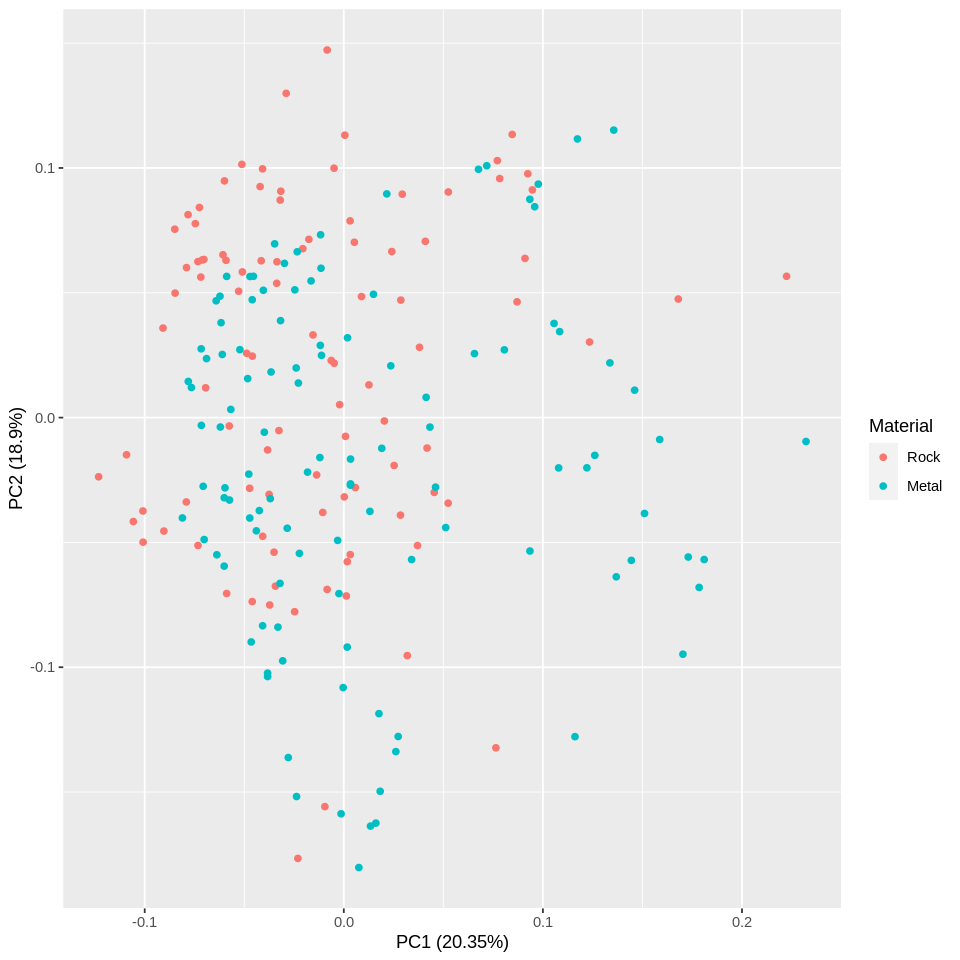

In [11]:
# This function returns the results as an object of class ‘prcomp’. We will assign the output to a variable named sonar_pca.
sonar_pca <- prcomp(sonar[,c(1:60)], 
                   center = TRUE, 
                   scale. = TRUE)

# Here we get four principal components named PC1-60. Each of these explains a percentage of the total variation in the dataset.
summary(sonar_pca)
#str(sonar_pca)

install.packages("ggfortify")
library(ggfortify)
sonar_pca_plot <- autoplot(sonar_pca, data = sonar, colour = 'Rocks_or_Mines') +
    labs(colour = "Material")
sonar_pca_plot

# For a better understanding of the linear transformation of features, biplot( ) function also be used to plot PCA.
# biplot_sonar_pca <- biplot(sonar_pca)
# biplot_sonar_pca

# For determining the ideal features which can be justified after performing PCA, the plot( ) function can be used to plot the precomp object.
# plot_sonar_pca <- plot(sonar_pca, type = '1')
# plot_sonar_pca


## 3. Discussion

Overall, the analysis suggests that given a vector of 60 incidence angle measurements, a KNN model is able to destinguish between rock and metal with a decent degree of accuracy. Specifically the model is able to predict with an accuracy of around 90% on an unseen dataset.

This result is a bit unexpected as the distribution of rock and metal measurements do not look optimal for KNN classification. This can be seen in the PCA plot where the rock and metal data points look randomly scattered and does not seem to have distinguishable clusters. It is also unusual how the testing accuracy is noticably higher than the optimal training accuracy, 90.2% and 83.5% respectively. This could be possibly due to overfitting as the optimal $k$ value, $2$ is quite low. However, it should also be noted that the optimal training accuracy of 83.5% is quite similar to the accuracy of 82.7% that was produced from the KNN algorithm in another paper (Gorman and Sejnowski, 1988). This suggests that a "lucky" testing set may have been another factor in the high testing accuracy.

A training and testing accuracy of 83.5% and 90.2% respectively combined with a very low optimal $k$ value of $2$ creates low confidence in the performance of this KNN model "in the wild". Furthermore, these results suggest that KNN may not be the best model for this type of problem and perhaps more sophisticated neural networks can result in much higher accuracies.

Dispite these shortcomings, these results show that automating the task of predicting an object's material from sonar measurements is possible and that a KNN model is not the best model for this problem.

In addition, it would be interesting to see if a predictive model could be applied to a larger range of material types intead of just rock and metal. Since neural nets were brought up as a potential solution to acheive higher accuracy, it would also be interesting to test the performance of various types of neural networks on this specific classification problem and verify if they truely can provide a significant improvement in accuracy.

## 4. References

**DELETE THIS COMMENT LATER BUT USE SOMEWHAT OF AN APA FORMAT FOR CONSISTANCY**

1. Dua, D. and Graff, C. (2019). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science.

2. Gorman, R. P., and Sejnowski, T. J. (1988). "Analysis of Hidden Units in a Layered Network Trained to Classify Sonar Targets" in Neural Networks, Vol. 1, pp. 75-89.

